In [23]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from tensorflow import keras
import keras_tuner
from keras.models import Model
from keras import layers
from keras import Input
from keras.layers import Dense, LeakyReLU, ReLU, Conv1D
from tensorflow.keras.utils import plot_model 
from imblearn.over_sampling import SMOTE,SVMSMOTE


In [24]:
def run_tests_ensamble(clfs, X_train, y_train, X_test, y_test):
    """
        returns the test auroc
    """
    pas1 = []
    pas2 = []
    for clf in clfs:
        # for X_train, X_test in zip(X_trains, X_tests):
        # fit each classifier on each data set variation
        t = clf.fit(X_train, y_train)
        pas1.append(t.predict_proba(X_test)[:, 1])
        pas2.append(t.predict_proba(X_train)[:, 1])

    pa1 = np.mean(pas1, axis=0)
    pa2 = np.mean(pas2, axis=0)

    print(pa1.shape, pa2.shape)

    # pred3 = trained.predict(X_val)
    # pa3 = trained.predict_proba(X_test)[:, 1]

    # IMPORTANT JUST SETTING YPRED TO 0 RN CUZ I DONT CARE ABOUT IT, SHOULD FIX LATER
    met1 = get_metrics('ensamble' + ' X_test', y_test, [0]*y_test.shape[0], pa1)
    met2 = get_metrics('ensamble' + ' X_train', y_train, [0]*y_train.shape[0], pa2)
    # met3 = get_metrics('ensamble' + ' X_val', y_val, pred3, pa3)

    print(f"({'ensamble'}) (X_test) accuracy, precision, recall, specificity, AUROC", met1)
    print(f"({'ensamble'}) (X_train) accuracy, precision, recall, specificity, AUROC", met2)

    return met1[4]
    # print(f"({'ensamble'}) (X_val) accuracy, precision, recall, specificity, AUROC", met3)

In [25]:
def get_metrics(name, y_test, y_pred, proba):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fn + fp)
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    specificity = tn / (tn+fp)
    roc_auc = roc_auc_score(y_test, proba)
    fpr, tpr, thresholds = roc_curve(y_test, proba, pos_label=1)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(name)
    plt.show()

    return accuracy, precision, recall, specificity, roc_auc

In [26]:
def prep_demo_data(y_train, y_test):
    X = pd.read_csv('train/train_demos.csv')
    X = X.set_index('patient_id')
    cat = ['gender', 'insurance', 'marital_status', 'ethnicity']
    # ONE HOT
    enc = OneHotEncoder()
    X_encoded = enc.fit_transform(X[cat])
    X_encoded = pd.DataFrame.sparse.from_spmatrix(X_encoded)
    X_encoded.index = X.index

    # LABEL
    # encoder = LabelEncoder()
    # X_encoded = X.copy()
    # for var in cat:
    #     X_encoded[var] = encoder.fit_transform(X_encoded[var])

    
    X = pd.concat([X.drop(cat, axis=1), X_encoded], axis=1)
    X['admittime'] = X.apply(lambda x: time.mktime(pd.Timestamp(x['admittime']).timetuple()), axis=1)
    X['admittime'] = X['admittime'] - X['admittime'].min()

    X_train = split(X, y_train.index)
    X_test = split(X, y_test.index)

    scaler = StandardScaler()
    scaler.fit(X_train[['age', 'admittime']])
    X_train[['age', 'admittime']] = scaler.transform(X_train[['age', 'admittime']])
    X_test[['age', 'admittime']] = scaler.transform(X_test[['age', 'admittime']])

    X_train.columns = X_train.columns.astype('str')
    X_test.columns = X_test.columns.astype('str')
    
    return X_train, X_test

In [27]:
def prep_signs_data(y_train, y_test):
    # CURRENTLY DROPS TIME COL
    signs = pd.read_csv('train/train_signs.csv')
    signs['charttime'] = pd.to_datetime(signs['charttime'])
    
    
    first_time_row = signs.groupby('patient_id')['charttime'].first()
    signs['firsttime'] = signs['patient_id'].map(first_time_row)
    # Sets the index as the time from the first reading so all patients start at 0 and go toward 24 hours
    signs['timediff'] = pd.to_numeric(signs['charttime'] - signs['firsttime'])
    signs = signs.drop(['charttime','firsttime'],axis=1)
    
    aggs = signs.groupby('patient_id').agg(['mean', 'min', 'max', 'first', 'last'])
    X_train = split(aggs, y_train.index)
    X_test = split(aggs, y_test.index)

    scaler = StandardScaler()
    features = X_train.columns
    id = X_train.index
    id_test = X_test.index

    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    X_train.columns = ['_'.join(x) for x in features]
    X_train.index = id
    X_test.columns = ['_'.join(x) for x in features]
    X_test.index = id_test

    # columns with more than 10% null values, drop these (10 columns, 2 metrics)
    drop_cols = X_train.columns[X_train.isna().sum() / X_train.shape[0] > .1] # should be just train set
    X_train = X_train.drop(columns=drop_cols)
    X_test = X_test.drop(columns=drop_cols)

    # is this the best way to do it??
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean()) # note train mean

    return X_train, X_test

In [28]:
#UNUSED
def DAE_dimensionality_reducer(X_train,X_test,dim=30):
    """
        Reduces the dimension of X to whatever dim is given using Denoising Auto Encoder, this can lead to worse performance if dim is choosen poorly
    """
    # Specify how much noise to add
    level_of_noise=0.0

    # Add random noise based on sampling from Gaussian distribution
    X_train_noisy = X_train + level_of_noise * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
    X_test_noisy = X_test + level_of_noise * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
    
    input_size = X_train.shape[1]
    # Defines network layers encoder - middle - decoder, middle is the undercomplete layer that should be sampled 
    visible = Input(shape=(input_size,), name='Input-Layer') # Specify input shape
    e = Dense(units=input_size, name='Encoder-Layer')(visible)
    e = LeakyReLU(name='Encoder-Layer-Activation')(e)
    m = Dense(units=dim, activation='linear', kernel_regularizer=keras.regularizers.L1L2(l1=1e-1,l2=1e-1), name='Middle-Hidden-Layer')(e)
    d = Dense(units=input_size, name='Decoder-Layer')(m)
    d = LeakyReLU(name='Decoder-Layer-Activation')(d)
    output = Dense(units=input_size, activation='sigmoid', name='Output-Layer')(d)

    # Define denoising autoencoder model
    model = Model(inputs=visible, outputs=output, name='Denoising-Autoencoder-Model')

    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile denoising autoencoder model
    model.compile(optimizer=opt, loss='mse')


    # Fit the Denoising autoencoder model to reconstruct original images
    history = model.fit(X_train_noisy, X_train, epochs=40, batch_size=32, verbose=0, validation_split=0.2)

    # Plot a loss chart
    display(model.summary())
    fig, ax = plt.subplots(figsize=(16,9), dpi=300)
    plt.title(label='DAE Model loss by Epoch', loc='center')
    ax.plot(history.history['loss'], label='Training Data', color='black')
    ax.plot(history.history['val_loss'], label='Test Data', color='red')
    ax.set(xlabel='Epoch', ylabel='Loss')
    plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
    plt.legend()

    plt.show()
    
    # Once model is trained we sample the middle layer as that is the lower dimensional representation
    dimensionality_reducing_model = Model(inputs=model.input, outputs=[model.layers[3].output])
    X_train_reduced = dimensionality_reducing_model.predict(X_train)

    return pd.DataFrame(dimensionality_reducing_model.predict(X_train),index=X_train.index),  pd.DataFrame(dimensionality_reducing_model.predict(X_test),index=X_test.index)

In [29]:
# UNUSED
def RNN_DAE_dimensionality_reducer(X_train,X_test,dim=30,epochs=300):
    """
        Reduces the dimension of X to whatever dim is given using Denoising Auto Encoder, this can lead to worse performance if dim is choosen poorly
    """
    # Specify how much noise to add
    level_of_noise=0.5

    # Add random noise based on sampling from Gaussian distribution
    X_train_noisy = X_train + level_of_noise * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

    timesteps = X_train.shape[1]
    input_dim = X_train.shape[2] 
    latent_dim = dim

    inputs = keras.Input(shape=(timesteps, input_dim))
    encoded = layers.LSTM(latent_dim)(inputs)
    middle = layers.Dense(latent_dim)(encoded)

    decoded = layers.RepeatVector(timesteps)(middle)
    decoded = layers.LSTM(input_dim, return_sequences=True)(decoded)

    sequence_autoencoder = keras.Model(inputs, decoded,name='RNN-DAE')
    encoder = keras.Model(inputs, middle,name="Encoder")
    
    opt = keras.optimizers.Adam(learning_rate=0.001)
    sequence_autoencoder.compile(optimizer=opt, loss='mse')

    history = sequence_autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=128, verbose=1, validation_split=0.2)
    
    # Plot a loss chart
    display(sequence_autoencoder.summary())
    fig, ax = plt.subplots(figsize=(16,9), dpi=300)
    plt.title(label='DAE Model loss by Epoch', loc='center')
    ax.plot(history.history['loss'], label='Training Data', color='black')
    ax.plot(history.history['val_loss'], label='Test Data', color='red')
    ax.set(xlabel='Epoch', ylabel='Loss')
    plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
    plt.legend()

    plt.show()
    

    return encoder.predict(X_train), encoder.predict(X_test)

In [30]:
def train_test(balance_train=False):
    # returns the train test split labels
    y = pd.read_csv('train/train_labels.csv')
    y = y.set_index('patient_id')
    y_train = y.sample(n=int(y.shape[0] * .8))
    y_test = y.drop(y_train.index)
    if balance_train:
        # RUN THIS CELL IF YOU WANT AN EVEN DATA CLASS BALANCE
        keep_ids = y_train[y_train['label'] == 0].sample(n=y_train['label'].sum()).index
        ys = y_train[y_train['label'] == 1].index
        y_train = y_train.loc[[*keep_ids, *ys]]
    return y_train, y_test


In [31]:
def train_test_create_samples(balance_train=False):
    # returns the train test split labels
    y = pd.read_csv('train/train_labels.csv')
    y = y.set_index('patient_id')
    y_train = y.sample(n=int(y.shape[0] * .8))
    y_test = y.drop(y_train.index)
    if balance_train:
        num_ones = y_train[y_train['label'] == 1].count()
        num_zeroes = y_train[y_train['label'] == 0].count()
        
        y_train = pd.concat([y_train,y_train[y_train['label'] == 1].sample(n=(num_zeroes-num_ones).iloc[0],replace=True)])
    return y_train, y_test

In [32]:
def split(X, index):
    return X.loc[index]

In [33]:
def prep_radiology_data(y_train, y_test):
    df = pd.read_csv('train/train_radiology.csv')
    df = df.groupby('patient_id').agg({'text': ['sum']})

    
    X_train = split(df, y_train.index)
    X_test = split(df, y_test.index)    
    
    # vectorizer = 
    # (sublinear_tf=True, max_df=.5, min_df=5, max_features=100, stop_words="english")
    vec_train = vectorizer.fit_transform(X_train['text']['sum'])
    vec_test = vectorizer.transform(X_test['text']['sum'])
    X_train = pd.concat([X_train.drop(columns=['text']), pd.DataFrame(vec_train.toarray(), index=y_train.index)], axis=1)
    X_test = pd.concat([X_test.drop(columns=['text']), pd.DataFrame(vec_test.toarray(), index=y_test.index)], axis=1)
    
    # X_train[('charttime','first')] = pd.to_datetime(X_train[('charttime','first')])
    # X_train[('charttime','last')] = pd.to_datetime(X_train[('charttime','last')])
    # X_test[('charttime','first')] = pd.to_datetime(X_test[('charttime','first')])
    # X_test[('charttime','last')] = pd.to_datetime(X_test[('charttime','last')])

    scaler = StandardScaler()
    features = X_train.columns
    id = X_train.index
    id_test = X_test.index

    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    X_train.columns = features
    X_train.index = id
    X_test.columns = features
    X_test.index = id_test

    return X_train, X_test

In [34]:
def sign_data_to_rnn(df):
    """
    Takes a dataframe of sign data to a numpy array grouped by patients * cols -> patients * timestep * cols
    """
    df['charttime'] = pd.to_datetime(df['charttime'])

    #Creates new column 'firsttime' which is the time of first row for each patient
    first_time_row = df.groupby('patient_id')['charttime'].first()
    df['firsttime'] = df['patient_id'].map(first_time_row)
    # Sets the index as the time from the first reading so all patients start at 0 and go toward 24 hours
    df = df.set_index(df['charttime'] - df['firsttime'])
    df = df.drop(['charttime','firsttime'],axis=1)
    # Resamples data so all patients have exactly 24 hours
    df = df.groupby('patient_id').resample('h').mean()
    df = df.reindex(pd.MultiIndex.from_product([df.index.levels[0],pd.timedelta_range(start='00:00:00', end='23:00:00', freq='6h')]))
    df = df.groupby(level=['patient_id']).ffill().bfill()
    # Fills NA with zero, na here means a patient that never had a certain measurment taken
    df[df.isna()] = 0
    
    num_patients = len(df.index.levels[0])
    num_cols = len(df.columns)
    d = np.array(df)
    index = df.index.levels[0]
    # patients * cols (30) * hours (24)
    d=np.reshape(d,(num_patients,num_cols,-1))
    d = np.swapaxes(d,1,2)
    return d,index
    

In [35]:
def rnn_prep_signs(y_train,y_test):
    """
    reads train_signs and turns it into time series data with 30 columns and 24 hours for each person
    """
    
    df = pd.read_csv('train/train_signs.csv')
    df = df.set_index('patient_id')
    
    X_train = split(df, y_train.index).reset_index()
    X_test = split(df, y_test.index).reset_index()
    X_train,index_train = sign_data_to_rnn(X_train)
    X_test,index_test = sign_data_to_rnn(X_test)

    scaler = StandardScaler()
    timesteps = X_train.shape[1]
    dim = X_train.shape[2]
    X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0]*X_train.shape[1],-1))
    X_test = scaler.transform(X_test.reshape(-1,dim))


    X_train = X_train.reshape(-1,timesteps,dim)
    X_test = X_test.reshape(-1,timesteps,dim)
    return X_train, X_test

In [36]:
from gensim.test.utils import common_texts, simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def prep_rad_doc_vec(y_train,y_test):
    df = pd.read_csv('train/train_radiology.csv')
    df = df.groupby('patient_id').agg({'text': ['sum']})
    X_train = split(df, y_train.index)
    X_test = split(df, y_test.index)    
    train_corpus = [TaggedDocument(simple_preprocess(doc), [X_train.index[i]]) for i, doc in enumerate(X_train['text']['sum'])]
    model = Doc2Vec(train_corpus, vector_size=30, window=1, min_count=100, workers=4,epochs=100,dm=1)
    model.build_vocab(train_corpus)
    model.train(train_corpus,total_examples=model.corpus_count,epochs=model.epochs)
    keys = model.dv.index_to_key
    X_train = pd.DataFrame({key : model.dv[key] for key in keys}).transpose()
    X_test = pd.DataFrame({patient_id:model.infer_vector(simple_preprocess(X_test['text']['sum'].loc[patient_id])) for i,patient_id in enumerate(X_test.index)}).transpose()
    return X_train,X_test

X_train, X_test = prep_rad_doc_vec(y_train,y_test)
# rad,rad_test = prep_radiology_data(y_train,y_test)
# X_train = pd.concat([rad_train,X_train], axis=1)
# X_test = pd.concat([rad_test,X_test], axis=1)
svc = svm.SVC()
svc.fit(X_train,y_train)

roc_auc_score(y_test,svc.predict(X_test))


/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6367686627493092

In [ ]:
y_train, y_test = train_test(balance_train=True)

In [17]:
rad_train, rad_test = prep_radiology_data(y_train, y_test)
rad_doc_train,rad_doc_test = prep_rad_doc_vec(y_train,y_test)
demo_train, demo_test = prep_demo_data(y_train, y_test)
sign_train,sign_test = prep_signs_data(y_train,y_test)

X_train = pd.concat([rad_train,sign_train, demo_train,rad_doc_train], axis=1)
X_test = pd.concat([rad_test,sign_test,  demo_test,rad_doc_test], axis=1)
X_just_rad_train = rad_train
X_jst_rad_test = rad_test
X_train.columns = X_train.columns.astype('str')
X_test.columns = X_test.columns.astype('str')
print(rad_train.shape,demo_train.shape,sign_train.shape)

NameError: name 'vectorizer' is not defined

In [232]:
# Doesn't improve performance, we will continue undersampling
# sm = SVMSMOTE(random_state=42)
# from imblearn.over_sampling import ADASYN
# sm = ADASYN(random_state=42)
# X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
# X_train_sm.shape

/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


(2742,) (2064,)


/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_r

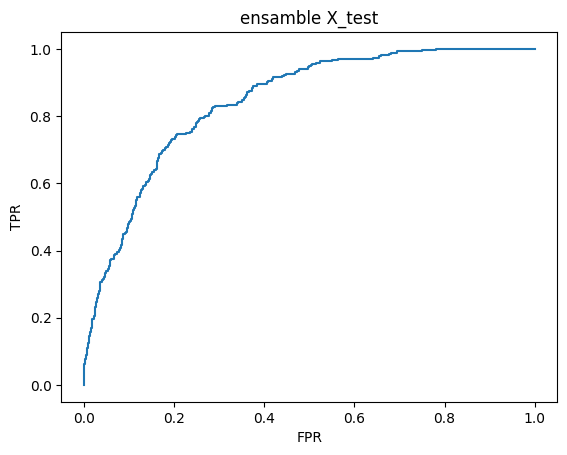

/var/folders/qd/q50f4_v16n7fp25tfl78t3ph0000gn/T/ipykernel_99467/1136690420.py:4: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp+fp)


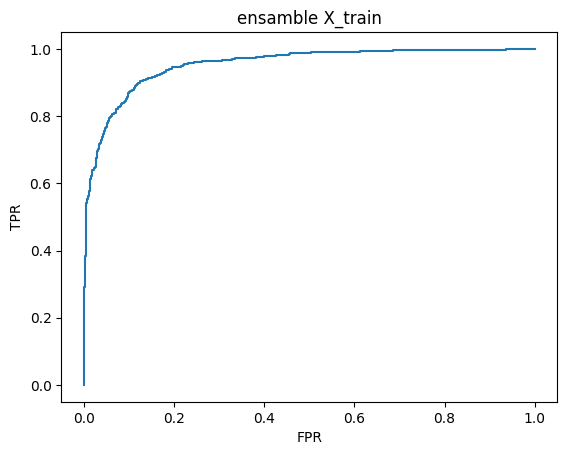

(ensamble) (X_test) accuracy, precision, recall, specificity, AUROC (0.9008023340627279, nan, 0.0, 1.0, 0.8430682900690641)
(ensamble) (X_train) accuracy, precision, recall, specificity, AUROC (0.5, nan, 0.0, 1.0, 0.9533156060332915)


0.8430682900690641

In [233]:
# svm
svc = svm.SVC(kernel='rbf', probability=True)
logreg = LogisticRegression()
# run_tests(svc, 'SVC', X_train, y_train, X_test, y_test)
# run_tests(logreg, 'Logistic', X_train, y_train, X_test, y_test)

run_tests_ensamble([svc, logreg], X_train, y_train, X_test, y_test)

In [ ]:
## NN TIME

In [37]:


sign_train, sign_test = prep_signs_data(y_train, y_test)
rad_train, rad_test = prep_radiology_data(y_train, y_test)
demo_train, demo_test = prep_demo_data(y_train, y_test)
print(sign_train.shape,rad_train.shape,demo_train.shape)
# rad_train, rad_test = DAE_dimensionality_reducer(rad_train,rad_test,dim=100)

X_train = pd.concat([sign_train, rad_train, demo_train], axis=1)
X_test = pd.concat([sign_test, rad_test, demo_test], axis=1)

X_train.columns = X_train.columns.astype('str')
X_test.columns = X_test.columns.astype('str')

NameError: name 'vectorizer' is not defined

In [72]:
def train_NN(X_train,y_train,neurons):
    input_size = X_train.shape[1]

    model = keras.Sequential([
            layers.Dense(input_size, activation="tanh", name='Input-Layer'),
            layers.Dense(units=96,activation="tanh", kernel_regularizer=keras.regularizers.L1L2(l1=1e-2, l2=1e-2),name='Hidden-Layer-1'),
            layers.Dropout(0.5),
            layers.Dense(units=1,activation='sigmoid',name='Output')
    ])

    for lr in [1e-4,1e-6]:
        opt = keras.optimizers.Adam(learning_rate=lr)
        callbacks = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5) 
        model.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.AUC()])
        model.fit(X_train,y_train,validation_split=0.1,epochs=1000,callbacks=[callbacks])
    return model


In [198]:

def train_k_NN(k,X,y):
    """
    Trains k neural networks over different folds of the provided training data
    
    Returns a list of trained models, and saves them to files at models/model{i}.keras where i is the model number
    """
    models = []
    for i in range(k):
        y_train = y.sample(n=int(y.shape[0] * .9))
        y_val = y.drop(y_train.index)
        X_train = X.loc[y_train.index]
        X_val= X.loc[y_val.index]
        input_size = X_train.shape[1]
        model = keras.Sequential([
            layers.Dense(input_size, activation="tanh", name='Input-Layer'),
            layers.Dense(units=96,activation="tanh", kernel_regularizer=keras.regularizers.L1L2(l1=1e-2, l2=1e-2),name='Hidden-Layer-1'),
            layers.Dropout(0.5),
            layers.Dense(units=1,activation='sigmoid',name='Output')
        ])
        for lr in [1e-4,1e-5,1e-6]:
            opt = keras.optimizers.Adam(learning_rate=lr)
            callbacks = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5) 
            model.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.AUC()])
            model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=1000,callbacks=[callbacks],verbose=0)
            model.save(f'models/model{i}.keras')
        models.append(model)
    return models
            
            
        

In [199]:
models = train_k_NN(10,X_train,y_train)

In [204]:
for k in range(10):
    model = keras.models.load_model(f'models/model{k}.keras')
    nn_predict = model.predict(X_test)
    print(f"NN{k}: ",roc_auc_score(y_test,nn_predict))

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
NN0:  0.8480960103996754
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
NN1:  0.8438493726451841
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
NN2:  0.8477850153242822
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
NN3:  0.8488952677434353
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
NN4:  0.8436161263386394
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
NN5:  0.847539329214722
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
NN6:  0.8435725870280846
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
NN7:  0.8458692856598616
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
NN8:  0.8457355577774426
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
NN9:  0.8475175595594445


In [20]:
y_train, y_test = train_test(balance_train=True)

In [21]:
rad_train, rad_test = prep_radiology_data(y_train, y_test)
demo_train, demo_test = prep_demo_data(y_train, y_test)
sign_train,sign_test = prep_signs_data(y_train,y_test)


X_train = pd.concat([rad_train,sign_train, demo_train], axis=1)
X_test = pd.concat([rad_test,sign_test,  demo_test], axis=1)

# X_train,X_test = DAE_dimensionality_reducer(X_train,X_test)

X_train.columns = X_train.columns.astype('str')
X_test.columns = X_test.columns.astype('str')
print(X_train.shape,X_test.shape)

NameError: name 'vectorizer' is not defined

In [22]:
# input_size = X_train.shape[1]
history = []
model = keras.Sequential([
        # layers.Dense(256, activation="tanh", name='Input-Layer', kernel_regularizer=keras.regularizers.L1L2(l1=1e-2,l2=1e-2)),
        # layers.Dropout(0.5),
        layers.Dense(units=90,activation="tanh",name='Hidden-Layer-1',kernel_regularizer=keras.regularizers.L1L2(l1=1e-3,l2=1e-3)),
        layers.Dropout(0.5),
        layers.Dense(units=1,activation='sigmoid',name='Output')
])

for lr in [1e-4,1e-5,1e-6]:
    opt = keras.optimizers.Adam(learning_rate=lr)
    callbacks = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3) 
    model.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.AUC()])
    history.append(model.fit(X_train,y_train,validation_split=0.1,epochs=1000,callbacks=[callbacks]))
    
model.summary()

NameError: name 'X_train' is not defined

In [18]:
print("train")
model.evaluate(X_train, y_train)
print("prediction")
model.evaluate(X_test, y_test)
display(model.summary())
for h in history:
    fig, ax = plt.subplots(figsize=(16,9), dpi=300)
    plt.title(label='Model loss by Epoch', loc='center')
    ax.plot(h.history['loss'], label='Training Data', color='black')
    ax.plot(h.history['val_loss'], label='Test Data', color='red')
    ax.set(xlabel='Epoch', ylabel='Loss')
    plt.xticks(ticks=np.arange(len(h.history['loss'])), labels=np.arange(1, len(h.history['loss'])+1))
    plt.legend()

plt.show()


train


NameError: name 'model' is not defined

In [127]:
(model.predict(X_test) > 0.5).sum()

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


0

In [114]:
(y_test > 0.5).sum()

label    276
dtype: int64

In [148]:
nn_predict = model.predict(X_test)

svc = svm.SVC(kernel='rbf', probability=True)
fit_svc = svc.fit(X_train, y_train)
svc_predict = fit_svc.predict_proba(X_test)[:, 1].reshape(-1,1)
svc_train_predict = fit_svc.predict_proba(X_train)[:, 1].reshape(-1,1)

logreg = LogisticRegression()
fit_logreg = logreg.fit(X_train, y_train)
logreg_predict = fit_logreg.predict_proba(X_test)[:, 1].reshape(-1,1)
logreg_train_predict = fit_logreg.predict_proba(X_train)[:, 1].reshape(-1,1)


ensemble_predict = (logreg_predict + nn_predict + svc_predict) / 3
ensemble_nnless_predict = (logreg_predict  + svc_predict) / 2
print("NN: ",roc_auc_score(y_test,nn_predict))
print("SVC: ",roc_auc_score(y_test,svc_predict))
print("LOGREG: ",roc_auc_score(y_test,logreg_predict))
print("ENSEMBLE: ",roc_auc_score(y_test,ensemble_predict))
print("Without NN," ,roc_auc_score(y_test,ensemble_nnless_predict))

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


NN:  0.833063216434003
SVC:  0.8447993039004276
LOGREG:  0.8297037793667006
ENSEMBLE:  0.8460318541217418
Without NN, 0.8461105436386335


/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_r

In [234]:
# Add all of the models predictions to the input data and use this to train a final model
X_train_w_models = pd.DataFrame(index=y_train.index)
X_test_w_models = pd.DataFrame(index=y_test.index)
X_train_w_models['svc'] = svc_train_predict
X_train_w_models['logreg'] = logreg_train_predict
X_test_w_models['svc'] = svc_predict
X_test_w_models['logreg'] = logreg_predict
for i in range(10):
    model = keras.models.load_model(f'models/model{i}.keras')
    X_train_w_models[f'NN{i}'] = model.predict(X_train,verbose=0)
    X_test_w_models[f'NN{i}'] = model.predict(X_test,verbose=0)
    

In [243]:
model = train_NN(X_train_w_models,y_train,neurons=10)

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input-Layer (Dense)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden-Layer-1 (Dense)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - auc_46: 0.5089 - loss: 2.2541 - val_auc_46: 0.0000e+00 - val_loss: 2.2390
Epoch 2/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_46: 0.5091 - loss: 2.2490 - val_auc_46: 0.0000e+00 - val_loss: 2.2266
Epoch 3/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_46: 0.5282 - loss: 2.2359 - val_auc_46: 0.0000e+00 - val_loss: 2.2141
Epoch 4/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc_46: 0.5270 - loss: 2.2303 - val_auc_46: 0.0000e+00 - val_loss: 2.2037
Epoch 5/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc_46: 0.5217 - loss: 2.2229 - val_auc_46: 0.0000e+00 - val_loss: 2.1945
Epoch 6/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc_46: 0.5548 - loss: 2.2102 - val_auc_46: 0.0000e+00 - val_loss: 2.1827
Epoch 7/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc_46: 0.5342 - loss: 2.2084 - val_auc_46: 0.0000e+00 - val_loss: 2.1719
Epoch 8/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc_46: 0.5442 - loss: 2.1977 - val_auc_46: 0.0000

In [245]:
nn_predict = model.predict(X_test_w_models)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [247]:
print("FINAL ENSEMBLE NN: ",roc_auc_score(y_test,nn_predict))

FINAL ENSEMBLE NN:  0.822063900915219


In [367]:
# Function for running a random search over a keras model, acts as a first pass for model design
auc = keras.metrics.AUC()
loss = keras.losses.BinaryCrossentropy()
def build_random_model(hp):
    
    model = keras.Sequential()
    j = 0
    for i in range(1, hp.Int("num_layers", 2, 4)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
                kernel_regularizer=keras.regularizers.L1L2(l1=1e-2,l2=1e-2),
                activation="relu",
                name='Hidden-Layer-'+str(i))
            )
        
        # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
        model.add(keras.layers.Dropout(0.5)) 
    
    
    model.add(keras.layers.Dense(1, activation='sigmoid',name='Output'))
    
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=loss,metrics=[auc])
    return model

In [370]:
tuner = keras_tuner.RandomSearch(
    build_random_model,
    objective=keras_tuner.Objective('val_loss','min'),
    max_trials=300,
    overwrite=True,
    directory="random_search",
    project_name="v1"
)

tuner.search(X_train, y_train, epochs=200, validation_split=0.1,batch_size=128)


Trial 300 Complete [00h 00m 22s]
val_loss: 0.7240146398544312

Best val_loss So Far: 0.6984740495681763
Total elapsed time: 01h 53m 45s


In [371]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

/Users/benware/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden-Layer-1 (Dense)          │ (None, 96)             │        25,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,153 (98.25 KB)

 Trainable params: 25,153 (98.25 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
X_train.shape

(2106, 260)

In [147]:
#L1L2 seems no good
# learning rate = 1e-5 essential bigger learning rate val error just noise
# Want later layers to be smaller than earlier ones
# Not sure about optimal dropout

In [49]:
# Second pass grid search centered on best params found in random search
auc = keras.metrics.AUC()
loss = keras.losses.BinaryCrossentropy()
best_params = tuner.get_best_hyperparameters()[0].values
print(best_params)
def build_grid_model(hp):
    
    model = keras.Sequential()
    
    for i in range(1, best_params['num_layers']+1):
        units = "units_" + str(i)
        name = 'Hidden-Layer-'+str(i)
        model.add(
            keras.layers.Dense(
                units=hp.Int(units, min_value=32, max_value=1024, step=32, default=best_params[units]),
                kernel_regularizer=keras.regularizers.L1L2(l1=1e-4,l2=1e-3),
                activation="relu",
                name=name,
            ))
        
        # Add dropout to all layers except last one
        if i != 5:
            model.add(keras.layers.Dropout(0.5))
    
    
    model.add(keras.layers.Dense(1, activation='sigmoid',name='Output'))
    
    model.compile(optimizer='adam', loss=loss,metrics=[auc])
    return model

{'units_1': 512, 'dropout_1': 0.1, 'units_2': 288, 'dropout_2': 0.2, 'units_3': 320, 'dropout_3': 0.1, 'units_4': 96, 'dropout_4': 0.1, 'units_5': 128, 'dropout_5': 0.2}


In [52]:
# Tune binary cross entropy directly as that is the loss function in the model and training AUC may lead to overfitting
tuner = keras_tuner.GridSearch(
    build_grid_model,
    objective=keras_tuner.Objective('val_'+loss.name,'min'),
    max_trials=300,
    overwrite=True,
    directory="grid_search",
    project_name="v1"
)

tuner.search(X_train, y_train, epochs=15, validation_split=0.2)

KeyError: 'num_layers'

In [24]:
# Random search result :0.873 val AUC
# {'num_layers': 5, 'units_1': 512, 'l1': 0.0001, 'l2': 0.001, 'dropout_1': 0.1, 'units_2': 288, 'dropout_2': 0.2, 'units_3': 320, 'dropout_3': 0.1, 'units_4': 96, 'dropout_4': 0.1, 'units_5': 128, 'dropout_5': 0.0}
best_params = tuner.get_best_hyperparameters()

for params in best_params:
    print(params.values)

{'num_layers': 5, 'units_1': 512, 'l1': 0.0001, 'l2': 0.001, 'dropout_1': 0.1, 'units_2': 288, 'dropout_2': 0.2, 'units_3': 320, 'dropout_3': 0.1, 'units_4': 96, 'dropout_4': 0.1, 'units_5': 128, 'dropout_5': 0.0}


/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.D

(2742,) (2116,)


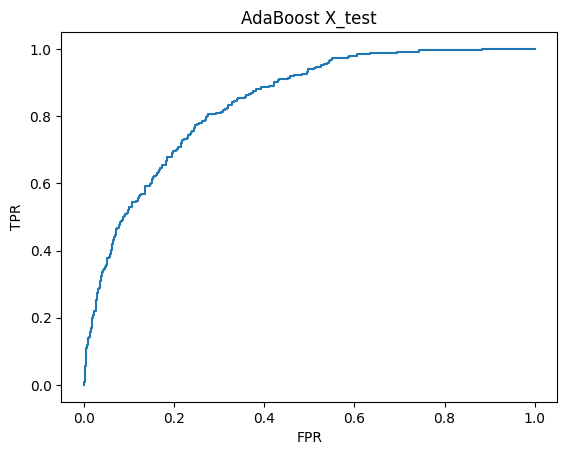

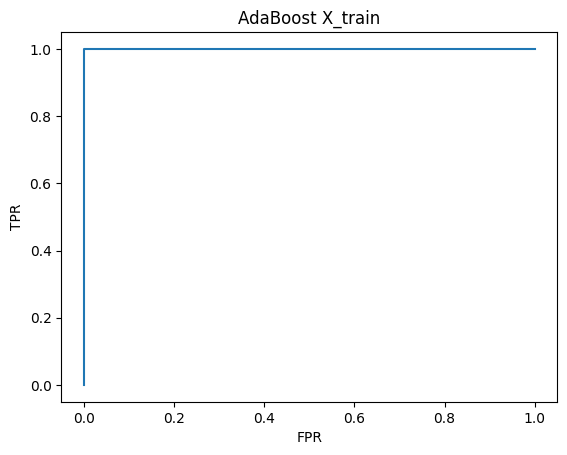

(AdaBoost) Time to train 19.642624855041504
(AdaBoost) Avg time to classify 2.9403740780619615e-05
(AdaBoost) (X_test) accuracy, precision, recall, specificity, AUROC (0.7392414296134209, 0.22573099415204678, 0.7845528455284553, 0.7347756410256411, 0.8410823170731708)
(AdaBoost) (X_train) accuracy, precision, recall, specificity, AUROC (1.0, 1.0, 1.0, 1.0, 1.0)


0.8410823170731708

In [39]:
clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10),n_estimators=100, algorithm="SAMME", random_state=0)
run_tests(clf, 'AdaBoost', X_train, y_train, X_test, y_test)

In [34]:
history = model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=1, validation_split=0.2)

# Plot a loss chart
display(model.summary())
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model loss by Epoch', loc='center')
ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
plt.legend()

plt.show()
print("train")
model.evaluate(X_train, y_train)
print("prediction")
model.evaluate(X_test, y_test)


NameError: name 'model' is not defined